In [1]:
# load dataset data/test.csv and data/train.csv

import pandas as pd

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print(train.shape, test.shape)

train.head()

(120000, 2) (7600, 2)


,text,label
0,wall st bear claw back black reuters reuters s...,2
1,carlyle look toward commercial aerospace reute...,2
2,oil economy cloud stock outlook reuters reuter...,2
3,iraq halt oil export main southern pipeline re...,2
4,oil price soar alltime record posing new menac...,2


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create a TF-IDF vectorizer object for english
tfidf = TfidfVectorizer(stop_words='english')

# fit the object with the training data
tfidf.fit(train.text)

# transform the training data
train_tfidf = tfidf.transform(train.text)

# transform the test data
test_tfidf = tfidf.transform(test.text)

print(train_tfidf.shape, test_tfidf.shape)

(120000, 77346) (7600, 77346)


In [4]:
from sklearn.decomposition import NMF

# Number of topics
n_topics = 4

# Apply NMF for topic modeling on the vectorized data
nmf = NMF(n_components=n_topics, random_state=0).fit(train_tfidf)

# transform the training data
train_nmf = nmf.transform(train_tfidf)

# transform the test data
test_nmf = nmf.transform(test_tfidf)

print(train_nmf.shape, test_nmf.shape)

(120000, 4) (7600, 4)


In [5]:
import numpy as np

# Get the dominant topic for each 
dominant_topics = np.argmax(train_nmf, axis=1)

# distribution of dominant topics
import pandas as pd
pd.Series(dominant_topics).value_counts()

2    50372
3    38116
0    23064
1     8448
Name: count, dtype: int64

In [7]:
# print the top 15 words for each topic
feature_names = tfidf.get_feature_names_out()

for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic #{topic_idx}:")
    # print the top words with their probabilities
    for i in topic.argsort()[:-15 - 1:-1]:
        print(f"{feature_names[i]}: {topic[i]}")
    print()

Topic #0:
iraq: 1.8247038852780297
killed: 1.0984934866086586
said: 1.0802099265321585
baghdad: 1.041751416609322
iraqi: 1.0322253890622186
palestinian: 0.8288482401731613
reuters: 0.8078017329568064
minister: 0.7447413427799785
attack: 0.7331201212726134
gaza: 0.7204022186042668
bomb: 0.7198893539772919
official: 0.6930813927250526
people: 0.6870486057258245
israeli: 0.6856797297126844
troop: 0.6428108338915496

Topic #1:
oil: 2.514658666143305
price: 1.81171933046436
stock: 1.207309070638586
crude: 0.7094566988308733
reuters: 0.6948115885771046
barrel: 0.5624070989338137
high: 0.5092787541469056
york: 0.4833935631750864
higher: 0.460843747842044
supply: 0.44826926033951364
record: 0.44042066422543796
new: 0.42076582071382873
dollar: 0.41187887323180306
investor: 0.32017400940893614
rise: 0.3110487350959498

Topic #2:
microsoft: 1.0054822337916027
company: 0.8614608525094983
new: 0.8563284314935864
software: 0.6262624477566844
corp: 0.6059501623699178
said: 0.5865528763806339
service:

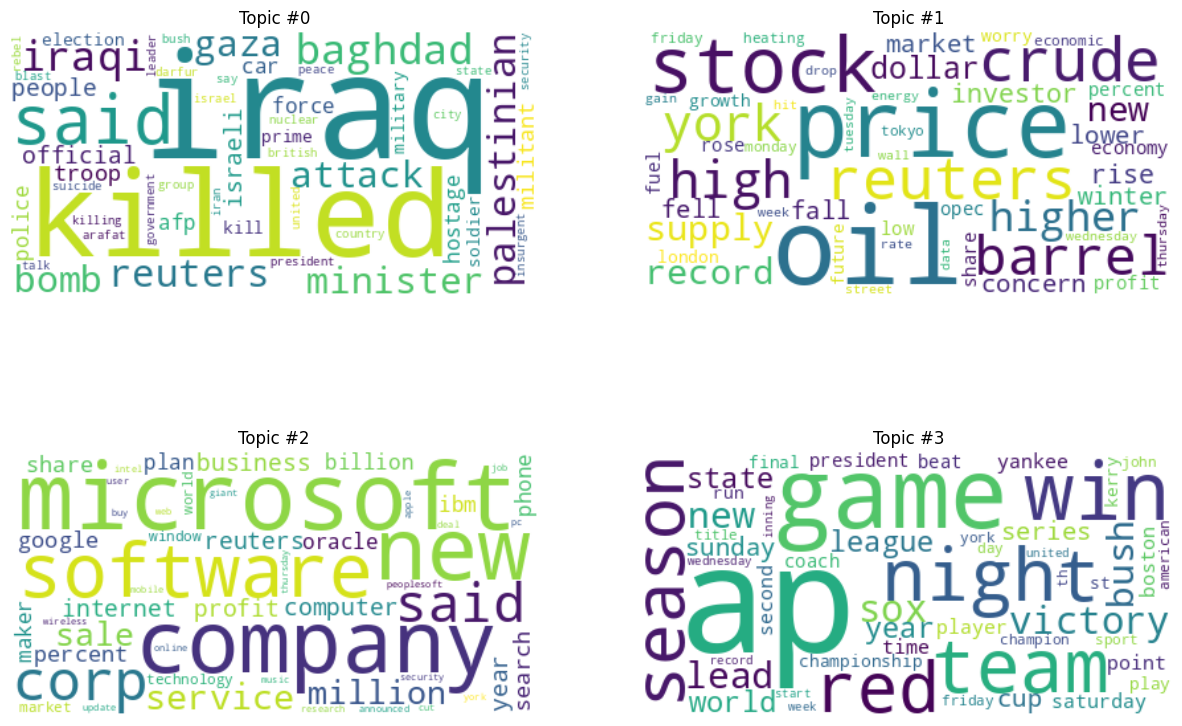

In [11]:
# use wordclouds to visualize each topic
from wordcloud import WordCloud
from matplotlib import pyplot as plt

# Creating a word cloud for each topic
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

# no need to visualize the top 15, just visualize ALL the words
for topic_idx, topic in enumerate(nmf.components_):
    # create a dataframe with words and their probabilities
    df = pd.DataFrame([feature_names, topic]).T
    df.columns = ['words', 'probabilities']
    # create a dictionary with words and their probabilities
    words = dict(zip(df.words, df.probabilities))
    # create the wordcloud
    wc = WordCloud(background_color='white', max_words=50)
    wc.generate_from_frequencies(words)
    # plot the wordcloud
    axs[topic_idx].imshow(wc, interpolation='bilinear')
    axs[topic_idx].set_title(f'Topic #{topic_idx}')
    axs[topic_idx].axis('off')
    
plt.show()

In [8]:
import pandas as pd

n_labels = 4

# Initialize a DataFrame to store label counts per topic
label_counts_per_topic = pd.DataFrame(0, index=range(n_topics), columns=range(n_labels))

# Loop over the training data, train is a df with columns ['text', 'label']
for i in range(len(train)):
    topic = dominant_topics[i]
    label = train.label[i]
    label_counts_per_topic.loc[topic, label] += 1

label_percentages_per_topic = label_counts_per_topic.divide(label_counts_per_topic.sum(axis=1), axis=0)

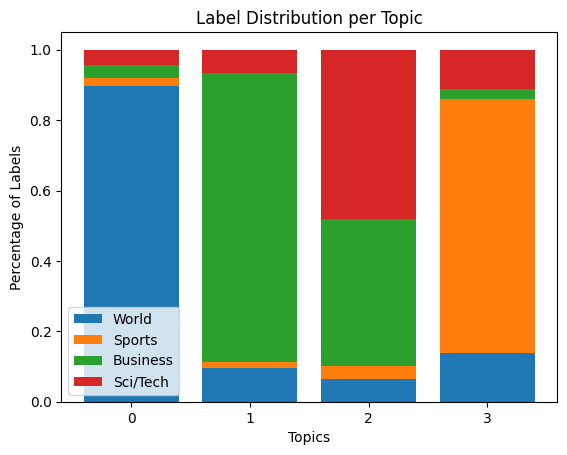

In [10]:
import matplotlib.pyplot as plt
import numpy as np

label_names = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

topic_label_count = np.zeros((n_topics, n_labels))

# Count the labels for each topic
for doc_idx, topic in enumerate(dominant_topics):
    label = train.label[doc_idx]
    topic_label_count[topic, label] += 1

# Convert counts to percentages
topic_label_percentage = topic_label_count / topic_label_count.sum(axis=1, keepdims=True)

# Plotting
fig, ax = plt.subplots()
for label in range(n_labels):
    # Compute bottom position for each bar
    bottom = np.sum(topic_label_percentage[:, :label], axis=1)
    ax.bar(range(n_topics), topic_label_percentage[:, label], bottom=bottom, label=label_names[label])

ax.set_xlabel('Topics')
ax.set_ylabel('Percentage of Labels')
ax.set_title('Label Distribution per Topic')
ax.set_xticks(range(n_topics))
ax.legend()
plt.show()

In [12]:
# let's do the same thing for the test data
# Get the dominant topic for each 
dominant_topics = np.argmax(test_nmf, axis=1)

pd.Series(dominant_topics).value_counts()

2    3217
3    2396
0    1454
1     533
Name: count, dtype: int64

In [15]:
# Initialize a DataFrame to store label counts per topic
label_counts_per_topic = pd.DataFrame(0, index=range(n_topics), columns=range(n_labels))

# Loop over the training data, train is a df with columns ['text', 'label']
for i in range(len(test)):
    topic = dominant_topics[i]
    label = test.label[i]
    label_counts_per_topic.loc[topic, label] += 1

label_percentages_per_topic = label_counts_per_topic.divide(label_counts_per_topic.sum(axis=1), axis=0)

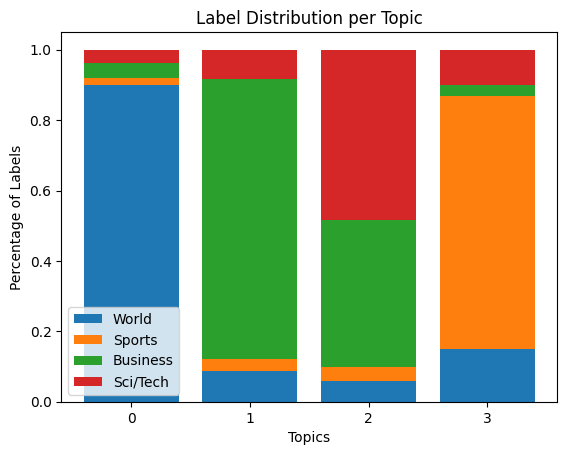

In [16]:
topic_label_count = np.zeros((n_topics, n_labels))

# Count the labels for each topic
for doc_idx, topic in enumerate(dominant_topics):
    label = test.label[doc_idx]
    topic_label_count[topic, label] += 1

# Convert counts to percentages
topic_label_percentage = topic_label_count / topic_label_count.sum(axis=1, keepdims=True)

# Plotting
fig, ax = plt.subplots()
for label in range(n_labels):
    # Compute bottom position for each bar
    bottom = np.sum(topic_label_percentage[:, :label], axis=1)
    ax.bar(range(n_topics), topic_label_percentage[:, label], bottom=bottom, label=label_names[label])

ax.set_xlabel('Topics')
ax.set_ylabel('Percentage of Labels')
ax.set_title('Label Distribution per Topic')
ax.set_xticks(range(n_topics))
ax.legend()
plt.show()